# Convolutional Autoencoder Training for Anomaly Detection @ L1Trigger

# Packages

In [1]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve, auc
import tensorflow_probability as tfp

import keras_tuner
from keras_tuner import Hyperband

import joblib

# Input files reading

All input files are already sorted in Calo regions (i, j) ~ (18, 14)<br>
Where i = 0 -> 17 corresponds to GCT_Phi = 0 -> 17<br>
Where j = 0 -> 13 corresponds to RCT_Eta = 4 -> 17

Keep this ordering as is when feeding into neural nets. Also keep this in mind when generating/preparing new samples.

Zerobias and MC signal files:

In [2]:
'''
ZeroBiasA0 = h5py.File('bkg/ZeroBias2018RunA_0.h5', 'r')
ZeroBiasA1 = h5py.File('bkg/ZeroBias2018RunA_1.h5', 'r')
ZeroBiasA2 = h5py.File('bkg/ZeroBias2018RunA_2.h5', 'r')
ZeroBiasA0 = np.stack((ZeroBiasA0['CaloRegions'][:].astype('float32'),
                       (~ZeroBiasA0['ElectronBit'][:]+2).astype('float32'),
                       (~ZeroBiasA0['TauBit'][:]+2).astype('float32')))
ZeroBiasA1 = np.stack((ZeroBiasA1['CaloRegions'][:].astype('float32'),
                       (~ZeroBiasA1['ElectronBit'][:]+2).astype('float32'),
                       (~ZeroBiasA1['TauBit'][:]+2).astype('float32')))
ZeroBiasA2 = np.stack((ZeroBiasA2['CaloRegions'][:].astype('float32'),
                       (~ZeroBiasA2['ElectronBit'][:]+2).astype('float32'),
                       (~ZeroBiasA2['TauBit'][:]+2).astype('float32')))
ZeroBiasA0 = np.moveaxis(ZeroBiasA0, 0, -1)
ZeroBiasA1 = np.moveaxis(ZeroBiasA1, 0, -1)
ZeroBiasA2 = np.moveaxis(ZeroBiasA2, 0, -1)
ZeroBiasA = np.concatenate((ZeroBiasA0, ZeroBiasA1, ZeroBiasA2))
del ZeroBiasA0
del ZeroBiasA1
del ZeroBiasA2
'''

ZeroBias = h5py.File('bkg/EphemeralZeroBias2018RunD_1.h5', 'r')
ZeroBias = np.stack((ZeroBias['CaloRegions'][:500000].astype('float32'),
                     ZeroBias['EGBit'][:500000].astype('float32'),
                     ZeroBias['TauBit'][:500000].astype('float32')))
ZeroBias = np.moveaxis(ZeroBias, 0, -1)

print('ZeroBias shape: ' + str(ZeroBias.shape))

MC_files = []
MC_files.append('bkg/110X/QCD_Pt-15to7000_TuneCP5_Flat_14TeV_0.h5')#i=0
MC_files.append('bkg/120X/SingleNeutrino_E-10-gun_0.h5')#i=1
MC_files.append('bkg/120X/SingleNeutrino_Pt-2To20-gun_0.h5')#i=2
'''
MC_files.append('sig/110X/GluGluToHHTo4B_node_SM_TuneCP5_14TeV.h5')#i=3
MC_files.append('sig/110X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/VBFHToTauTau_M125_TuneCUETP8M1_14TeV.h5')
MC_files.append('sig/110X/VBF_HH_CV_1_C2V_1_C3_1_TuneCP5_PSweights_14TeV.h5')
MC_files.append('sig/110X/VBF_HToInvisible_M125_TuneCUETP8M1_14TeV.h5')
MC_files.append('sig/110X/VectorZPrimeToQQ_M100_pT300_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/VectorZPrimeToQQ_M200_pT300_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/VectorZPrimeToQQ_M50_pT300_TuneCP5_14TeV.h5')#i=13
MC_files.append('sig/110X/ZprimeToZH_MZprime1000_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/ZprimeToZH_MZprime600_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
MC_files.append('sig/110X/ZprimeToZH_MZprime800_MZ50_MH80_ZTouds_HTouds_narrow_TuneCP5_14TeV.h5')
'''

MC_files.append('sig/120X/GluGluHToTauTau_M-125_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/GluGluToHHTo4B_node_cHHH1_TuneCP5_14TeV.h5')
'''
MC_files.append('sig/120X/GluGluToHHTo4B_node_cHHH5_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-100000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-12_CTau-9000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')#i=23
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-25_CTau-15000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-30000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-120_CTau-1000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-250_MFF-60_CTau-1000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-1000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-160_CTau-500mm_TuneCP5_14TeV.h5')#i=33
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-1000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4b_MH-350_MFF-80_CTau-500mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4mu_MH-1000_MFF-450_CTau-10000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-12_CTau-900mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-25_CTau-1500mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/HTo2LongLivedTo4mu_MH-125_MFF-50_CTau-3000mm_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-1200_TuneCP5_13TeV-pythia814TeV.h5')
MC_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-120_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-350_TuneCP5_14TeV.h5')#i=43
MC_files.append('sig/120X/SUSYGluGluToBBHToBB_NarrowWidth_M-600_TuneCP5_14TeV.h5')
'''
MC_files.append('sig/120X/TT_TuneCP5_14TeV.h5')
'''
MC_files.append('sig/120X/TprimeBToTH_M-650_LH_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VBFHHTo4B_CV_1_C2V_2_C3_1_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VBFHToInvisible_M125_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VBFHToTauTau_M125_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VectorZPrimeGammaToQQGamma_M-10_GPt-75_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VectorZPrimeToQQ_M-100_Pt-300_TuneCP5_14TeV.h5')
MC_files.append('sig/120X/VectorZPrimeToQQ_M-200_Pt-300_TuneCP5_14TeV.h5')#i=52
MC_files.append('sig/120X/emj-mMed-800-mDark-10-ctau-0p1.h5')
MC_files.append('sig/120X/emj-mMed-800-mDark-10-ctau-1.h5')
MC_files.append('sig/120X/emj-mMed-800-mDark-10-ctau-1000.h5')
MC_files.append('sig/120X/emj-mMed-800-mDark-10-ctau-150.h5')
'''
MC_files.append('sig/120X/haa4b_ma15_powheg.h5')
'''
MC_files.append('sig/120X/haa4b_ma15_powheg_FlatPU0To80.h5')
MC_files.append('sig/120X/haa4b_ma50_powheg.h5')
MC_files.append('sig/120X/haa4taus_ma15_powheg.h5')
'''

MC = []
for i in range(len(MC_files)):
    MC.append(h5py.File(MC_files[i], 'r'))
    MC[i] = np.stack((MC[i]['CaloRegions'][:500000].astype('float32'),
                      MC[i]['EGBit'][:500000].astype('float32'),
                      MC[i]['TauBit'][:500000].astype('float32')))
    MC[i] = np.moveaxis(MC[i], 0, -1)
    print('i = ' + str(i) + ': ' + str(MC[i].shape))

ZeroBias shape: (500000, 18, 14, 3)
i = 0: (500000, 18, 14, 3)
i = 1: (500000, 18, 14, 3)
i = 2: (500000, 18, 14, 3)
i = 3: (300000, 18, 14, 3)
i = 4: (100000, 18, 14, 3)
i = 5: (500000, 18, 14, 3)
i = 6: (98600, 18, 14, 3)


See distributions of EG/Tau bits

In [ ]:
table_EGTau_FF = []
table_EGTau_TF = []
table_EGTau_FT = []
table_EGTau_TT = []

table_EGTau_FF_pt = []
table_EGTau_TF_pt = []
table_EGTau_FT_pt = []
table_EGTau_TT_pt = []

bits = []
bits_pt = []
for n in range(1000):
    for i in range(18):
        for j in range(14):
            if ZeroBias[n,i,j,1]==0 and ZeroBias[n,i,j,2]==0:
                bits.append(1)
                if ZeroBias[n,i,j,0]>10:
                    bits_pt.append(1)
            if ZeroBias[n,i,j,1]==1 and ZeroBias[n,i,j,2]==0:
                bits.append(2)
                if ZeroBias[n,i,j,0]>10:
                    bits_pt.append(2)
            if ZeroBias[n,i,j,1]==0 and ZeroBias[n,i,j,2]==1:
                bits.append(3)
                if ZeroBias[n,i,j,0]>10:
                    bits_pt.append(3)
            if ZeroBias[n,i,j,1]==1 and ZeroBias[n,i,j,2]==1:
                bits.append(4)
                if ZeroBias[n,i,j,0]>10:
                    bits_pt.append(4)
                
table_EGTau_FF.append(np.round(bits.count(1)/(len(bits))*100,5))
table_EGTau_TF.append(np.round(bits.count(2)/(len(bits))*100,5))
table_EGTau_FT.append(np.round(bits.count(3)/(len(bits))*100,5))
table_EGTau_TT.append(np.round(bits.count(4)/(len(bits))*100,5))

table_EGTau_FF_pt.append(np.round(bits_pt.count(1)/(len(bits))*100,5))
table_EGTau_TF_pt.append(np.round(bits_pt.count(2)/(len(bits))*100,5))
table_EGTau_FT_pt.append(np.round(bits_pt.count(3)/(len(bits))*100,5))
table_EGTau_TT_pt.append(np.round(bits_pt.count(4)/(len(bits))*100,5))

for k in range(len(MC_files)):
    bits = []
    bits_pt = []
    for n in range(MC[k].shape[0]):
        for i in range(18):
            for j in range(14):
                if MC[k][n,i,j,1]==0 and MC[k][n,i,j,2]==0:
                    bits.append(1)
                    if MC[k][n,i,j,0]>10:
                        bits_pt.append(1)
                if MC[k][n,i,j,1]==1 and MC[k][n,i,j,2]==0:
                    bits.append(2)
                    if MC[k][n,i,j,0]>10:
                        bits_pt.append(2)
                if MC[k][n,i,j,1]==0 and MC[k][n,i,j,2]==1:
                    bits.append(3)
                    if MC[k][n,i,j,0]>10:
                        bits_pt.append(3)
                if MC[k][n,i,j,1]==1 and MC[k][n,i,j,2]==1:
                    bits.append(4)
                    if MC[k][n,i,j,0]>10:
                        bits_pt.append(4)
    
    table_EGTau_FF.append(np.round(bits.count(1)/(len(bits))*100,5))
    table_EGTau_TF.append(np.round(bits.count(2)/(len(bits))*100,5))
    table_EGTau_FT.append(np.round(bits.count(3)/(len(bits))*100,5))
    table_EGTau_TT.append(np.round(bits.count(4)/(len(bits))*100,5))
    
    table_EGTau_FF_pt.append(np.round(bits_pt.count(1)/(len(bits))*100,5))
    table_EGTau_TF_pt.append(np.round(bits_pt.count(2)/(len(bits))*100,5))
    table_EGTau_FT_pt.append(np.round(bits_pt.count(3)/(len(bits))*100,5))
    table_EGTau_TT_pt.append(np.round(bits_pt.count(4)/(len(bits))*100,5))

In [ ]:
files_table=[]
files_table.append('EphemeralZeroBias2018RunD')
for i in range(len(MC_files)):
    files_table.append(MC_files[i])

table_EGTau = pd.DataFrame({'Both OFF': np.round(table_EGTau_FF,3),
                            'EG-only': np.round(table_EGTau_TF,3),
                            'Tau-only': np.round(table_EGTau_FT,3),
                            'Both ON': np.round(table_EGTau_TT,3)},
                            index = files_table)

table_EGTau_pt = pd.DataFrame({'pt>10, Both OFF': np.round(table_EGTau_FF_pt,3),
                               'pt>10, EG-only': np.round(table_EGTau_TF_pt,3),
                               'pt>10, Tau-only': np.round(table_EGTau_FT_pt,3),
                               'pt>10, Both ON': np.round(table_EGTau_TT_pt,3)},
                               index = files_table)

table_EG = pd.DataFrame({'EG OFF': np.round(table_EGTau_FF,2)+np.round(table_EGTau_FT,2),
                         'EG ON': np.round(table_EGTau_TF,2)+np.round(table_EGTau_TT,2)},
                         index = files_table)

table_EG_pt = pd.DataFrame({'pt>10, EG OFF': np.round(table_EGTau_FF_pt,2)+np.round(table_EGTau_FT_pt,2),
                            'pt>10, EG ON': np.round(table_EGTau_TF_pt,2)+np.round(table_EGTau_TT_pt,2)},
                            index = files_table)

table_Tau = pd.DataFrame({'Tau OFF': np.round(table_EGTau_FF,2)+np.round(table_EGTau_TF,2),
                          'Tau ON': np.round(table_EGTau_FT,2)+np.round(table_EGTau_TT,2)},
                          index = files_table)

table_Tau_pt = pd.DataFrame({'pt>10, Tau OFF': np.round(table_EGTau_FF_pt,2)+np.round(table_EGTau_TF_pt,2),
                             'pt>10, Tau ON': np.round(table_EGTau_FT_pt,2)+np.round(table_EGTau_TT_pt,2)},
                             index = files_table)

table_EGTau = table_EGTau.drop(index=[MC_files[0],MC_files[1],MC_files[2]])
table_EGTau_pt = table_EGTau_pt.drop(index=[MC_files[0],MC_files[1],MC_files[2]])
table_EG = table_EG.drop(index=[MC_files[0],MC_files[1],MC_files[2]])
table_EG_pt = table_EG_pt.drop(index=[MC_files[0],MC_files[1],MC_files[2]])
table_Tau = table_Tau.drop(index=[MC_files[0],MC_files[1],MC_files[2]])
table_Tau_pt = table_Tau_pt.drop(index=[MC_files[0],MC_files[1],MC_files[2]])

pd.set_option('display.max_colwidth', None)
display(table_EGTau)
display(table_EGTau_pt)
display(table_EG)
display(table_EG_pt)
display(table_Tau)
display(table_Tau_pt)

In [ ]:
del table_EGTau_FF, table_EGTau_TF, table_EGTau_FT, table_EGTau_TT
del table_EGTau_FF_pt, table_EGTau_TF_pt, table_EGTau_FT_pt, table_EGTau_TT_pt
del bits, bits_pt
del files_table, table_EGTau, table_EGTau_pt, table_EG, table_EG_pt, table_Tau, table_Tau_pt

In [ ]:
@@@@ masking

In [ ]:
ZeroBias_masked = np.empty(shape=ZeroBias.shape, dtype=int)
ZeroBias_masked[:,:,:,0] = ZeroBias[:,:,:,0] * (1 - ZeroBias[:,:,:,1]) * (1 - ZeroBias[:,:,:,2])
ZeroBias_masked[:,:,:,1] = ZeroBias[:,:,:,0] * ZeroBias[:,:,:,1]
ZeroBias_masked[:,:,:,2] = ZeroBias[:,:,:,0] * ZeroBias[:,:,:,2]

MC_masked = []
for i in range(len(MC_files)):
    MC_masked.append(np.empty(shape=MC[i].shape, dtype=int))
    MC_masked[i][:,:,:,0] = MC[i][:,:,:,0] * (1 - MC[i][:,:,:,1]) * (1 - MC[i][:,:,:,2])
    MC_masked[i][:,:,:,1] = MC[i][:,:,:,0] * MC[i][:,:,:,1]
    MC_masked[i][:,:,:,2] = MC[i][:,:,:,0] * MC[i][:,:,:,2]

Visualize Et and EG/Tau bits per event

In [ ]:
for n in range(1230,1231):
    bits = np.empty(shape = (18,14,3), dtype = 'object')
    for i in range(18):
        for j in range(14):
            if ZeroBias[n,i,j,0]==0:
                bits[i,j,0] = ' '
            if ZeroBias[n,i,j,0]>0:
                bits[i,j,0] = ZeroBias[n,i,j,0].astype(int)
            if ZeroBias[n,i,j,1]==0:
                bits[i,j,1] = ' '
            if ZeroBias[n,i,j,1]==1:
                bits[i,j,1] = 'EG'
            if ZeroBias[n,i,j,2]==0:
                bits[i,j,2] = ' '
            if ZeroBias[n,i,j,2]==1:
                bits[i,j,2] = 'Tau'
    
    fig, ax = plt.subplots(figsize = (18,18))
    ax = plt.subplot(2, 2, 1)
    ax = sns.heatmap(ZeroBias[n,:,:,0], vmin = 0, vmax = ZeroBias[n,:,:,0].max(), annot = bits[:,:,0], fmt = '', linewidths = 0.1, cmap = "Blues", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('EphemeralZeroBias2018RunD\nAnnotation = Et (GeV)')

    ax = plt.subplot(2, 2, 2)
    ax = sns.heatmap(ZeroBias[n,:,:,0], vmin = 0, vmax = ZeroBias[n,:,:,0].max(), annot = bits[:,:,1], fmt = '', linewidths = 0.1, cmap = "Blues", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('EphemeralZeroBias2018RunD\nAnnotation = EGamma bit (bool)')
    
    ax = plt.subplot(2, 2, 3)
    ax = sns.heatmap(ZeroBias[n,:,:,0], vmin = 0, vmax = ZeroBias[n,:,:,0].max(), annot = bits[:,:,2], fmt = '', linewidths = 0.1, cmap = "Blues", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('EphemeralZeroBias2018RunD\nAnnotation = Tau bit (bool)')
    
    plt.show()
    
del bits

In [ ]:
for n in range(1233,1236):
    mask = np.empty(shape = (18,14,3), dtype = 'object')
    for i in range(18):
        for j in range(14):
            if ZeroBias_masked[n,i,j,0]==0:
                mask[i,j,0] = ' '
            if ZeroBias_masked[n,i,j,0]>0:
                mask[i,j,0] = ZeroBias_masked[n,i,j,0]
            if ZeroBias_masked[n,i,j,1]==0:
                mask[i,j,1] = ' '
            if ZeroBias_masked[n,i,j,1]>0:
                mask[i,j,1] = ZeroBias_masked[n,i,j,1]
            if ZeroBias_masked[n,i,j,2]==0:
                mask[i,j,2] = ' '
            if ZeroBias_masked[n,i,j,2]>0:
                mask[i,j,2] = ZeroBias_masked[n,i,j,2]
                
    fig, ax = plt.subplots(figsize = (18,18))
    ax = plt.subplot(2, 2, 1)
    ax = sns.heatmap(ZeroBias_masked[n,:,:,0], vmin = 0, vmax = ZeroBias[n,:,:,0].max(), annot = mask[:,:,0], fmt = '', linewidths = 0.1, cmap = "Blues", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('EphemeralZeroBias2018RunD\nAnnotation = Et without EG/Tau (GeV)')

    ax = plt.subplot(2, 2, 2)
    ax = sns.heatmap(ZeroBias_masked[n,:,:,1], vmin = 0, vmax = ZeroBias[n,:,:,0].max(), annot = mask[:,:,1], fmt = '', linewidths = 0.1, cmap = "Blues", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('EphemeralZeroBias2018RunD\nAnnotation = Et with EGbit (GeV)')
    
    ax = plt.subplot(2, 2, 3)
    ax = sns.heatmap(ZeroBias_masked[n,:,:,2], vmin = 0, vmax = ZeroBias[n,:,:,0].max(), annot = mask[:,:,2], fmt = '', linewidths = 0.1, cmap = "Blues", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('EphemeralZeroBias2018RunD\nAnnotation = Et with Taubit (GeV)')
    
    plt.show()
del mask

In [ ]:
k=4
for n in range(193,194):
    bits = np.empty(shape = (18,14,3), dtype = 'object')
    for i in range(18):
        for j in range(14):
            if MC[k][n,i,j,0]==0:
                bits[i,j,0] = ' '
            if MC[k][n,i,j,0]>0:
                bits[i,j,0] = MC[k][n,i,j,0].astype(int)
            if MC[k][n,i,j,1]==0:
                bits[i,j,1] = ' '
            if MC[k][n,i,j,1]==1:
                bits[i,j,1] = 'EG'
            if MC[k][n,i,j,2]==0:
                bits[i,j,2] = ' '
            if MC[k][n,i,j,2]==1:
                bits[i,j,2] = 'Tau'

    fig, ax = plt.subplots(figsize = (18,18))
    ax = plt.subplot(2, 2, 1)
    ax = sns.heatmap(MC[k][n,:,:,0], vmin = 0, vmax = MC[k][n,:,:,0].max(), annot = bits[:,:,0], fmt = '', linewidths = 0.1, cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('{}\nAnnotation = Et (GeV)'.format(MC_files[k]))

    ax = plt.subplot(2, 2, 2)
    ax = sns.heatmap(MC[k][n,:,:,0], vmin = 0, vmax = MC[k][n,:,:,0].max(), annot = bits[:,:,1], fmt = '', linewidths = 0.1, cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('{}\nAnnotation = EGamma bit (bool)'.format(MC_files[k]))
    
    ax = plt.subplot(2, 2, 3)
    ax = sns.heatmap(MC[k][n,:,:,0], vmin = 0, vmax = MC[k][n,:,:,0].max(), annot = bits[:,:,2], fmt = '', linewidths = 0.1, cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('{}\nAnnotation = Tau bit (bool)'.format(MC_files[k]))
    
    plt.show()
    
del bits

In [ ]:
k=5
for n in range(193,196):
    mask = np.empty(shape = (18,14,3), dtype = 'object')
    for i in range(18):
        for j in range(14):
            if MC_masked[k][n,i,j,0]==0:
                mask[i,j,0] = ' '
            if MC_masked[k][n,i,j,0]>0:
                mask[i,j,0] = MC_masked[k][n,i,j,0].astype(int)
            if MC_masked[k][n,i,j,1]==0:
                mask[i,j,1] = ' '
            if MC_masked[k][n,i,j,1]>0:
                mask[i,j,1] = MC_masked[k][n,i,j,1].astype(int)
            if MC_masked[k][n,i,j,2]==0:
                mask[i,j,2] = ' '
            if MC_masked[k][n,i,j,2]>0:
                mask[i,j,2] = MC_masked[k][n,i,j,2].astype(int)

    fig, ax = plt.subplots(figsize = (18,18))
    ax = plt.subplot(2, 2, 1)
    ax = sns.heatmap(MC_masked[k][n,:,:,0], vmin = 0, vmax = MC[k][n,:,:,0].max(), annot = mask[:,:,0], fmt = '', linewidths = 0.1, cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('{}\nAnnotation = Et without EG/Tau (GeV)'.format(MC_files[k]))

    ax = plt.subplot(2, 2, 2)
    ax = sns.heatmap(MC_masked[k][n,:,:,1], vmin = 0, vmax = MC[k][n,:,:,0].max(), annot = mask[:,:,1], fmt = '', linewidths = 0.1, cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('{}\nAnnotation = Et with EGbit (GeV)'.format(MC_files[k]))
    
    ax = plt.subplot(2, 2, 3)
    ax = sns.heatmap(MC_masked[k][n,:,:,2], vmin = 0, vmax = MC[k][n,:,:,0].max(), annot = mask[:,:,2], fmt = '', linewidths = 0.1, cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('{}\nAnnotation = Et with Taubit (GeV)'.format(MC_files[k]))
    
    plt.show()
    
del mask

Take a look at some ZB statistics.

In [ ]:
ZB_mean = np.mean(ZeroBias[:,:,:,0], axis = 0)

fig, ax = plt.subplots(figsize = (10,10))
ax = plt.subplot(2, 2, 2)
ax = sns.heatmap(ZB_mean.reshape(18, 14), vmin = 0, vmax = ZB_mean.max(), cmap = "Blues", cbar_kws = {'label': 'ET (GeV)'})
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Mean Et distribution (EphemeralZeroBias2018RunD)')
plt.show()

In [ ]:
plt.hist(ZeroBias[:,:,:,0].reshape((-1)), bins = 20, log = True)
plt.xlabel("ZeroBias Et")
plt.show()

print('Mean ZeroBias pT = ' + str(np.mean(ZeroBias.reshape(-1))))

# Hyperparameter searching (no quantization here)

If we want to train with custom loss functions.

In [ ]:
import tensorflow.keras.backend as K
def custom_loss_for_train():
    def func(y_true, y_pred):
        #MSE(output, input)
        loss = K.mean((y_pred - y_true)**2, axis = [1, 2, 3])
        
        #MSE(output, mean ZB)
        #loss = K.mean((y_pred - ZB_mean)**2, axis = [1, 2, 3])
        
        #MSE(output, 0) for denoising
        #loss = K.mean(y_pred**2, axis = [1, 2, 3])
        
        return loss
    return func

Hypermodel for convolutional autoencoder (usually a teacher model for Knowledge Distillation later).

In [ ]:
def hypermodel(hp):
    hp_model = tf.keras.Sequential()
    hp_model.add(tf.keras.layers.InputLayer(input_shape = (18, 14, 1)))
    hp_model.add(layers.Conv2D(filters = hp.Int('filters_1',
                                                min_value = 15,
                                                max_value = 25,
                                                step = 2),
                               kernel_size = (3, 3),
                               activation = 'relu',
                               strides = 1,
                               padding = 'same'))
    
    hp_model.add(layers.AveragePooling2D((2, 2)))
    hp_model.add(layers.Conv2D(filters = hp.Int('filters_2',
                                                min_value = 15,
                                                max_value = 25,
                                                step = 2),
                               kernel_size = (3, 3),
                               activation = 'relu',
                               strides = 1,
                               padding = 'same'))
    
    hp_model.add(layers.Conv2D(filters = 1,
                               kernel_size = (3, 3),
                               activation = 'relu',
                               strides = 1,
                               padding = 'same'))
    
    hp_model.add(layers.Conv2D(filters = hp.Int('filters_3',
                                                min_value = 15,
                                                max_value = 25,
                                                step = 2),
                               kernel_size = (3, 3),
                               activation = 'relu',
                               strides = 1,
                               padding = 'same'))
    
    hp_model.add(layers.UpSampling2D((2, 2)))
    hp_model.add(layers.Conv2D(filters = hp.Int('filters_4',
                                                min_value = 15,
                                                max_value = 25,
                                                step = 2),
                               kernel_size = (3, 3),
                               activation = 'relu',
                               strides = 1,
                               padding = 'same'))
    
    hp_model.add(layers.Conv2D(filters = 1, kernel_size = (3, 3), activation = 'relu', strides = 1, padding = 'same'))
    hp_model.compile(optimizer = 'adam', loss = custom_loss_for_train())
    return hp_model

Hypermodel for shallowly dense (usually a student model for Knowledge Distillation later).

In [ ]:
def hypermodel(hp):
    hp_model = tf.keras.Sequential()
    hp_model.add(tf.keras.layers.InputLayer(input_shape = (18, 14, 1)))
    hp_model.add(tf.keras.layers.Flatten())
    hp_model.add(tf.keras.layers.Dense(units = hp.Int('units_1',
                                                      min_value = 10,
                                                      max_value = 40,
                                                      step = 2),
                                       activation = 'relu'))
    hp_model.add(tf.keras.layers.Dropout(rate = 0.3))
    hp_model.add(tf.keras.layers.Dense(1, activation = 'relu'))
    hp_model.compile(optimizer = 'adam', loss = 'mse')
    return hp_model

Set configuration for tuner (Hyperband).

In [ ]:
tuner = Hyperband(hypermodel,
                 objective = 'val_loss',
                 max_epochs = 20,
                 factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                 hyperband_iterations = 2, #number of times to iterate over the full Hyperband algorithm
                 seed = 10,
                 directory = 'hypertuning',
                 project_name = 'tune',
                 overwrite = True)

Partition the dataset into train/val/test sets.

In [ ]:
X = ZeroBias

train_ratio = 0.75
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test = train_test_split(X, test_size = test_ratio, random_state = 123)
X_train, X_val = train_test_split(X_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 123)

Run the search. Mind the label when training for reconstruction or something else.

In [ ]:
tuner.search(X_train, X_train,
            epochs = 20,
            validation_data = (X_val, X_val),
            batch_size = 256)

Show the best models.

In [ ]:
tuner.results_summary(num_trials = 3)

Take one of them for later use.

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)
model.summary()

# Conv AE

Convolutional autoencoder to be trained for input reconstruction (to be used as a teacher model for Knowledge Distillation later).

The encoder part, transforming the (18, 14) region input into a smaller latent space.

In [ ]:
X = ZeroBias[:,:,:,0].reshape(-1,18,14,1)
#X = ZeroBias_masked

train_ratio = 0.5
val_ratio = 0.1
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test = train_test_split(X, test_size = test_ratio, random_state = 123)
X_train, X_val = train_test_split(X_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 123)

In [ ]:
encoder_input = tf.keras.Input(shape=(18,14,3), name='input')

encoder = layers.Conv2D(30, (3,3), strides=1, padding='same', name='conv2d_1')(encoder_input)
encoder = layers.Activation('relu', name='relu_1')(encoder)
encoder = layers.AveragePooling2D((2,2), name='pool_1')(encoder)
encoder = layers.Conv2D(40, (3,3), strides=1, padding='same', name='conv2d_2')(encoder)
encoder = layers.Activation('relu', name='relu_2')(encoder)
encoder = layers.Flatten(name='flatten')(encoder)

encoder_output = layers.Dense(120, activation='relu', name='latent')(encoder)

encoder = tf.keras.models.Model(encoder_input, encoder_output)
encoder.summary()

The decoder part, reconstructing from latent space back to the (18, 14) region input. Note the Conv2DTranspose is not yet supported in hls4ml, but ok to use if it is going to be distilled to another network. 

In [ ]:
decoder = layers.Dense(9*7*40, name='dense')(encoder_output)
decoder = layers.Reshape((9,7,40), name='reshape')(decoder)
decoder = layers.Activation('relu', name='relu_3')(decoder)
decoder = layers.Conv2D(40, (3,3), strides=1, padding='same', name='conv2d_3')(decoder)
decoder = layers.Activation('relu', name='relu_4')(decoder)
decoder = layers.UpSampling2D((2,2), name='upsampling')(decoder)
decoder = layers.Conv2D(30, (3,3), strides=1, padding='same', name='conv2d_4')(decoder)
decoder = layers.Activation('relu', name='relu_5')(decoder)

decoder_output = layers.Conv2D(3, (3,3), activation='relu', strides=1, padding='same', name='output')(decoder)

In [ ]:
model = tf.keras.Model(encoder_input, decoder_output)
model.summary()
#keras.utils.plot_model(encoder, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
@@@@@@@@@@@@@@@@@@@@ bits

In [ ]:
X = ZeroBias

train_ratio = 0.75
val_ratio = 0.2
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test = train_test_split(X, test_size = test_ratio, random_state = 123)
X_train, X_val = train_test_split(X_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 123)

In [ ]:
encoder_input = tf.keras.Input(shape=(18,14,1), name='Et_input')
encoder_Et = layers.Conv2D(20, (3,3), strides=1, padding='same', name='Et_conv2d_1')(encoder_input)
encoder_Et = layers.Activation('relu', name='Et_relu_1')(encoder_Et)
encoder_Et = layers.AveragePooling2D((2,2), name='Et_pooling')(encoder_Et)
encoder_Et = layers.Conv2D(30, (3,3), strides=1, padding='same', name='Et_conv2d_2')(encoder_Et)
encoder_Et = layers.Activation('relu', name='Et_relu_2')(encoder_Et)
encoder_Et = layers.Flatten(name='Et_flatten')(encoder_Et)
encoder_Et = layers.Dense(100, name='Et_dense')(encoder_Et)
encoder_Et = layers.Activation('relu', name='Et_relu_3')(encoder_Et)
encoder_Et = tf.keras.models.Model(encoder_input, encoder_Et)

encoder_input = tf.keras.Input(shape=(18,14,1), name='EG_input')
encoder_EG = layers.Conv2D(20, (3,3), strides=1, padding='same', name='EG_conv2d_1')(encoder_input)
encoder_EG = layers.Activation('relu', name='EG_relu_1')(encoder_EG)
encoder_EG = layers.AveragePooling2D((2,2), name='EG_pooling')(encoder_EG)
encoder_EG = layers.Conv2D(30, (3,3), strides=1, padding='same', name='EG_conv2d_2')(encoder_EG)
encoder_EG = layers.Activation('relu', name='EG_relu_2')(encoder_EG)
encoder_EG = layers.Flatten(name='EG_flatten')(encoder_EG)
encoder_EG = layers.Dense(100, name='EG_dense')(encoder_EG)
encoder_EG = layers.Activation('relu', name='EG_relu_3')(encoder_EG)
encoder_EG = tf.keras.models.Model(encoder_input, encoder_EG)

encoder_input = tf.keras.Input(shape=(18,14,1), name='Tau_input')
encoder_Tau = layers.Conv2D(20, (3,3), strides=1, padding='same', name='Tau_conv2d_1')(encoder_input)
encoder_Tau = layers.Activation('relu', name='Tau_relu_1')(encoder_Tau)
encoder_Tau = layers.AveragePooling2D((2,2), name='Tau_pooling')(encoder_Tau)
encoder_Tau = layers.Conv2D(30, (3,3), strides=1, padding='same', name='Tau_conv2d_2')(encoder_Tau)
encoder_Tau = layers.Activation('relu', name='Tau_relu_2')(encoder_Tau)
encoder_Tau = layers.Flatten(name='Tau_flatten')(encoder_Tau)
encoder_Tau = layers.Dense(100, name='Tau_dense')(encoder_Tau)
encoder_Tau = layers.Activation('relu', name='Tau_relu_3')(encoder_Tau)
encoder_Tau = tf.keras.models.Model(encoder_input, encoder_Tau)

encoder_output = layers.concatenate([encoder_Et.output, encoder_EG.output, encoder_Tau.output], name='latent_combine')
encoder_output = layers.Dense(100, name='latent_dense')(encoder_output)
encoder_output = layers.Activation('relu', name='latent_relu')(encoder_output)

encoder = tf.keras.models.Model([encoder_Et.input, encoder_EG.input, encoder_Tau.input], encoder_output)
encoder.summary()
#keras.utils.plot_model(encoder, show_shapes=True, show_layer_names=True)

In [ ]:
decoder = layers.Dense(9*7*20, name='decoder_dense')(encoder_output)
decoder = layers.Reshape((9,7,20), name='decoder_reshape')(decoder)
decoder = layers.Activation('relu', name='decoder_relu_1')(decoder)
decoder = layers.Conv2D(30, (3,3), strides=1, padding='same', name='decoder_conv2d_1')(decoder)
decoder = layers.Activation('relu', name='decoder_relu_2')(decoder)
decoder = layers.UpSampling2D((2,2), name='decoder_upsampling')(decoder)
decoder = layers.Conv2D(20, (3,3), strides=1, padding='same', name='decoder_conv2d_2')(decoder)
decoder = layers.Activation('relu', name='decoder_relu_3')(decoder)
decoder = layers.Conv2D(3, (3,3), strides=1, padding='same', name='decoder_conv2d_3')(decoder)
decoder = layers.Activation('relu', name='decoder_relu_4')(decoder)

#decoder = tf.keras.models.Model(encoder_output, decoder)
#decoder.summary()

In [ ]:
decoder_Et = layers.Dense(9*7*20, name='decoder_Et_dense')(encoder_output)
decoder_Et = layers.Reshape((9,7,20), name='decoder_Et_reshape')(decoder_Et)
decoder_Et = layers.Activation('relu', name='decoder_Et_relu_1')(decoder_Et)
decoder_Et = layers.Conv2D(30, (3,3), strides=1, padding='same', name='decoder_Et_conv2d_1')(decoder_Et)
decoder_Et = layers.Activation('relu', name='decoder_Et_relu_2')(decoder_Et)
decoder_Et = layers.UpSampling2D((2,2), name='decoder_Et_upsampling')(decoder_Et)
decoder_Et = layers.Conv2D(20, (3,3), strides=1, padding='same', name='decoder_Et_conv2d_2')(decoder_Et)
decoder_Et = layers.Activation('relu', name='decoder_Et_relu_3')(decoder_Et)
decoder_Et = layers.Conv2D(1, (3,3), strides=1, padding='same', name='decoder_Et_conv2d_3')(decoder_Et)
decoder_Et = layers.Activation('relu', name='decoder_Et_relu_4')(decoder_Et)
#decoder_Et = tf.keras.models.Model(encoder_output, decoder_Et)

decoder_EG = layers.Dense(9*7*20, name='decoder_EG_dense')(encoder_output)
decoder_EG = layers.Reshape((9,7,20), name='decoder_EG_reshape')(decoder_EG)
decoder_EG = layers.Activation('relu', name='decoder_EG_relu_1')(decoder_EG)
decoder_EG = layers.Conv2D(30, (3,3), strides=1, padding='same', name='decoder_EG_conv2d_1')(decoder_EG)
decoder_EG = layers.Activation('relu', name='decoder_EG_relu_2')(decoder_EG)
decoder_EG = layers.UpSampling2D((2,2), name='decoder_EG_upsampling')(decoder_EG)
decoder_EG = layers.Conv2D(20, (3,3), strides=1, padding='same', name='decoder_EG_conv2d_2')(decoder_EG)
decoder_EG = layers.Activation('relu', name='decoder_EG_relu_3')(decoder_EG)
decoder_EG = layers.Conv2D(1, (3,3), strides=1, padding='same', name='decoder_EG_conv2d_3')(decoder_EG)
decoder_EG = layers.Activation('relu', name='decoder_EG_relu_4')(decoder_EG)
#decoder_EG = tf.keras.models.Model(encoder_output, decoder_EG)

decoder_Tau = layers.Dense(9*7*20, name='decoder_Tau_dense')(encoder_output)
decoder_Tau = layers.Reshape((9,7,20), name='decoder_Tau_reshape')(decoder_Tau)
decoder_Tau = layers.Activation('relu', name='decoder_Tau_relu_1')(decoder_Tau)
decoder_Tau = layers.Conv2D(30, (3,3), strides=1, padding='same', name='decoder_Tau_conv2d_1')(decoder_Tau)
decoder_Tau = layers.Activation('relu', name='decoder_Tau_relu_2')(decoder_Tau)
decoder_Tau = layers.UpSampling2D((2,2), name='decoder_Tau_upsampling')(decoder_Tau)
decoder_Tau = layers.Conv2D(20, (3,3), strides=1, padding='same', name='decoder_Tau_conv2d_2')(decoder_Tau)
decoder_Tau = layers.Activation('relu', name='decoder_Tau_relu_3')(decoder_Tau)
decoder_Tau = layers.Conv2D(1, (3,3), strides=1, padding='same', name='decoder_Tau_conv2d_3')(decoder_Tau)
decoder_Tau = layers.Activation('relu', name='decoder_Tau_relu_4')(decoder_Tau)
#decoder_Tau = tf.keras.models.Model(encoder_output, decoder_Tau)

In [ ]:
model = tf.keras.Model([encoder_Et.input, encoder_EG.input, encoder_Tau.input], [decoder_Et,decoder_EG,decoder_Tau])
model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer = 'adam', loss = 'mse')

# Conv VAE

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 20
encoder_inputs = tf.keras.Input(shape = (18, 14, 1))

encoding = layers.Conv2D(20, (3, 3), strides = 1, padding = 'same')(encoder_inputs)
encoding = layers.Activation('relu')(encoding)
encoding = layers.AveragePooling2D((2, 2))(encoding)
encoding = layers.Conv2D(20, (3, 3), strides = 1, padding = 'same')(encoding)
encoding = layers.Activation('relu')(encoding)
encoding = layers.Flatten()(encoding)

z_mean = layers.Dense(latent_dim, name = 'z_mean')(encoding)
z_log_var = layers.Dense(latent_dim, name = 'z_log_var')(encoding)
z = Sampling()([z_mean, z_log_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name = 'encoder')
encoder.summary()

In [ ]:
latent_inputs = tf.keras.Input(shape = (latent_dim,))

decoding = layers.Dense(9 * 7 * 20)(latent_inputs)
decoding = layers.Reshape((9, 7, 20))(decoding)
decoding = layers.Activation('relu')(decoding)
decoding = layers.Conv2D(20, (3, 3), strides = 1, padding = 'same')(decoding)
decoding = layers.Activation('relu')(decoding)
decoding = layers.UpSampling2D((2, 2))(decoding)
decoding = layers.Conv2D(20, (3, 3), strides = 1, padding = 'same')(decoding)
decoding = layers.Activation('relu')(decoding)

decoder_outputs = layers.Conv2D(1, (3, 3), activation = 'sigmoid', strides = 1, padding = 'same')(decoding)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name = 'decoder')
decoder.summary()

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = 10*tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis = (1, 2)))
            #reconstruction_loss = 100*tf.reduce_mean(tf.square(data - reconstruction), axis = (1, 2, 3))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis = 1))
            #total_loss = reconstruction_loss + kl_loss
            #total_loss = reconstruction_loss
            total_loss = kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer = 'adam')

In [ ]:
et_scale = 1
history = vae.fit(X_train/et_scale, epochs = 8,
                  #validation_data = (X_val/et_scale,X_val/et_scale),
                  batch_size = 512)

In [ ]:
plt.figure(figsize = (15,10))
axes_left = plt.subplot(2, 2, 1)
axes_left.plot(history.history['loss'], label = 'Total loss = Reco + KL', c = 'g', linestyle = 'solid')
axes_left.plot(history.history['reconstruction_loss'], label = 'Reconstruction loss (BCE)', c = 'g' , linestyle = 'dashed')
axes_left.legend(loc = "upper left")
axes_left.set_xlabel('Epoch')
axes_left.set_ylabel('Total loss', c = 'g')

axes_right = axes_left.twinx()
axes_right.plot(history.history['kl_loss'], label = 'KL loss', c = 'r', linestyle = 'dashed')
axes_right.legend(loc = "upper right")
axes_right.set_ylabel('KL loss', c = 'r')

In [ ]:
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['kl_loss'], label = 'KL loss', c = 'r', linestyle = 'dashed')
axes.legend(loc = "upper left")
axes.set_yscale(value = "log")
axes.set_xlabel('Epoch')
axes.set_ylabel('KL loss', c = 'g')


In [ ]:
X_test_mu, X_test_logvar, X_test_z = vae.encoder.predict(X_test/et_scale)
X_test_predict = vae.decoder.predict(X_test_z)

MC_zb_mu = []
MC_zb_logvar = []
MC_zb_z = []
MC_zb_predict = []
for i in range(len(MC_zb)):
    mu, logvar, z = vae.encoder.predict(MC_zb[i]/et_scale)
    predict = vae.decoder.predict(z)
    MC_zb_mu.append(mu)
    MC_zb_logvar.append(logvar)
    MC_zb_z.append(z)
    MC_zb_predict.append(predict)

In [ ]:
i = 0
j = 1
n = 5

df_z_mu_sig = pd.DataFrame(MC_zb_mu[n][1:9000, i], columns = ["z_mu[{}]".format(i)])
df_z_mu_sig["z_mu[{}]".format(j)] = MC_zb_mu[n][1:9000, j]
df_z_mu_sig["dataset"] = MC_files[n]
df_z_mu_zb = pd.DataFrame(X_test_mu[1:9000, i], columns = ["z_mu[{}]".format(i)])
df_z_mu_zb["z_mu[{}]".format(j)] = X_test_mu[1:9000, j]
df_z_mu_zb["dataset"] = "test (ZB)"
df_z_mu = pd.concat([df_z_mu_sig,df_z_mu_zb])

df_z_sigma_sig = pd.DataFrame(np.exp(MC_zb_logvar[n][1:9000, i]/2), columns = ["z_sigma[{}]".format(i)])
df_z_sigma_sig["z_sigma[{}]".format(j)] = np.exp(MC_zb_logvar[n][1:9000, j]/2)
df_z_sigma_sig["dataset"] = MC_files[n]
df_z_sigma_zb = pd.DataFrame(np.exp(X_test_logvar[1:9000, i]/2), columns = ["z_sigma[{}]".format(i)])
df_z_sigma_zb["z_sigma[{}]".format(j)] = np.exp(X_test_logvar[1:9000, j]/2)
df_z_sigma_zb["dataset"] = "test (ZB)"
df_z_sigma = pd.concat([df_z_sigma_sig,df_z_sigma_zb])

df_z_sig = pd.DataFrame(np.exp(MC_zb_z[n][1:9000, i]/2), columns = ["z[{}]".format(i)])
df_z_sig["z[{}]".format(j)] = np.exp(MC_zb_z[n][1:9000, j]/2)
df_z_sig["dataset"] = MC_files[n]
df_z_zb = pd.DataFrame(np.exp(X_test_z[1:9000, i]/2), columns = ["z[{}]".format(i)])
df_z_zb["z[{}]".format(j)] = np.exp(X_test_z[1:9000, j]/2)
df_z_zb["dataset"] = "test (ZB)"
df_z = pd.concat([df_z_sig,df_z_zb])

plt.figure(figsize=(6, 6))
sns.jointplot(x = df_z_mu["z_mu[{}]".format(i)], y = df_z_mu["z_mu[{}]".format(j)], hue = df_z_mu["dataset"], height = 8, ratio = 5,
              #xlim = (-0.001, 0.001), ylim = (-0.001, 0.001),
              marker = '.', alpha = 1)
plt.show()

plt.figure(figsize=(6, 6))
sns.jointplot(x = df_z_sigma["z_sigma[{}]".format(i)], y = df_z_sigma["z_sigma[{}]".format(j)], hue = df_z_sigma["dataset"], height = 8, ratio = 5,
              #xlim = (-8, 8), ylim = (-8, 8),
              marker = '.', alpha = 1)
plt.show()

plt.figure(figsize=(6, 6))
sns.jointplot(x = df_z["z[{}]".format(i)], y = df_z["z[{}]".format(j)], hue = df_z["dataset"], height = 8, ratio = 5,
              #xlim = (-8, 8), ylim = (-8, 8),
              marker = '.', alpha = 1)
plt.show()

In [ ]:
def custom_loss_for_pred(y_true, y_pred, choice):
    #MSE
    if choice == 0:
        loss = np.mean((y_true - y_pred)**2, axis = (1, 2, 3))
        return loss
    
    #MSE for de-noising model
    if choice == 1:
        loss = np.mean(y_pred**2, axis = (1, 2, 3))
        return loss
    
    #VAE radius loss
    if choice == 2:
        loss = np.sqrt(np.sum(y_pred**2, axis = 1))
        return loss
    
    #VAE KL loss
    if choice == 3:
        loss = -0.5 * np.sum(1.0 + y_pred - y_true**2 - np.exp(y_pred), axis = 1)
        return loss
    
    #BCE loss
    if choice == 4:
        #loss = np.mean(np.sum(keras.losses.binary_crossentropy(y_true, y_pred), axis = (1, 2)))
        loss = np.sum(keras.losses.binary_crossentropy(y_true, y_pred), axis = (1, 2))
        return loss

In [ ]:
#For VAE
X_test_vaeloss_mse = custom_loss_for_pred(X_test/et_scale, X_test_predict, 0)
MC_zb_vaeloss_mse = []
for i in range(len(MC_zb)):
    MC_zb_vaeloss_mse.append(custom_loss_for_pred(MC_zb[i]/et_scale, MC_zb_predict[i], 0))
    
X_test_vaeloss_bce = custom_loss_for_pred(X_test/et_scale, X_test_predict, 4)
MC_zb_vaeloss_bce = []
for i in range(len(MC_zb)):
    MC_zb_vaeloss_bce.append(custom_loss_for_pred(MC_zb[i]/et_scale, MC_zb_predict[i], 4))

X_test_vaeloss_radius = custom_loss_for_pred(X_test, X_test_mu, 2)
MC_zb_vaeloss_radius = []
for i in range(len(MC_zb)):
    MC_zb_vaeloss_radius.append(custom_loss_for_pred(MC_zb[i], MC_zb_mu[i], 2))
    
X_test_vaeloss_kl = custom_loss_for_pred(X_test_mu, X_test_logvar, 3)
MC_zb_vaeloss_kl = []
for i in range(len(MC_zb)):
    MC_zb_vaeloss_kl.append(custom_loss_for_pred(MC_zb_mu[i], MC_zb_logvar[i], 3))

weight_mse = 0
weight_bce = 0
weight_radius = 0
weight_kl = 1.0

X_test_vaeloss = weight_mse*X_test_vaeloss_mse + weight_bce*X_test_vaeloss_bce + weight_radius*X_test_vaeloss_radius + weight_kl*X_test_vaeloss_kl
MC_zb_vaeloss = []
for i in range(len(MC_zb)):
    MC_zb_vaeloss.append(weight_mse*MC_zb_vaeloss_mse[i] + weight_bce*MC_zb_vaeloss_bce[i] + weight_radius*MC_zb_vaeloss_radius[i] + weight_kl*MC_zb_vaeloss_kl[i])

In [ ]:
#Original vs Reconstructed
#show_ZB = True
show_ZB = False
n = 5
for i in range(580,590):
    fig, ax = plt.subplots(figsize = (17,17))
    if show_ZB == True:
        print('ZB test\nloss = ' + str(X_test_vaeloss[i]))
    else:
        print(str(MC_files[n]) + '\nloss = ' + str(MC_zb_vaeloss[n][i]))
    ax = plt.subplot(3, 3, 1)
    if show_ZB == True:
        ax = sns.heatmap(X_test[i,:,:,0].reshape(18, 14)/et_scale, vmin = 0, vmax = X_test[i,:,:,0].max()/et_scale, cmap = "Blues", cbar_kws = {'label': 'Scaled ET'})
    else:
        ax = sns.heatmap(MC_zb[n][i,:,:,0].reshape(18, 14)/et_scale, vmin = 0, vmax = MC_zb[n][i,:,:,0].max()/et_scale, cmap = "Blues", cbar_kws = {'label': 'Scaled ET'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original')
    
    ax = plt.subplot(3, 3, 2)
    if show_ZB == True:
        ax = sns.heatmap(X_test_predict[i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max()/et_scale, cmap = "Blues", cbar_kws = {'label': 'Scaled ET'})
    else:
        ax = sns.heatmap(MC_zb_predict[n][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC_zb[n][i,:,:,0].max()/et_scale, cmap = "Blues", cbar_kws = {'label': 'Scaled ET'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Reconstructed')
    
    ax = plt.subplot(3, 3, 3)
    if show_ZB == True:
        ax = sns.heatmap(np.absolute(X_test_predict[i,:,:,0] - X_test[i,:,:,0]/et_scale).reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max()/et_scale, cmap = "Blues", cbar_kws = {'label': 'Scaled ET'})
    else:
        ax = sns.heatmap(np.absolute(MC_zb_predict[n][i,:,:,0] - MC_zb[n][i,:,:,0]/et_scale).reshape(18, 14), vmin = 0, vmax = MC_zb[n][i,:,:,0].max()/et_scale, cmap = "Blues", cbar_kws = {'label': 'Scaled ET'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('abs(original-reconstructed)')
    plt.show()

In [ ]:
nbins = 20
rmin = 0
rmax = 1000
plt.hist(X_test_vaeloss_mse, density = 1, bins = nbins, alpha = 0.3, label = 'test (ZeroBias)', range = (rmin, rmax), log = True)
plt.hist(MC_zb_vaeloss_mse[0], density = 1, bins = nbins, label = 'QCD', alpha = 0.1, histtype = 'stepfilled', range = (rmin, rmax))
for i in range(3,7):
    plt.hist(MC_zb_vaeloss_mse[i], density = 1, bins = nbins, label = MC_files[i], histtype = 'step', range = (rmin, rmax))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Reconstruction MSE loss")
plt.show()

nbins = 20
rmin = 0
rmax = 1000
plt.hist(X_test_vaeloss_bce, density = 1, bins = nbins, alpha = 0.3, label = 'test (ZeroBias)', range = (rmin, rmax), log = True)
plt.hist(MC_zb_vaeloss_bce[0], density = 1, bins = nbins, label = 'QCD', alpha = 0.1, histtype = 'stepfilled', range = (rmin, rmax))
for i in range(3,7):
    plt.hist(MC_zb_vaeloss_bce[i], density = 1, bins = nbins, label = MC_files[i], histtype = 'step', range = (rmin, rmax))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Reconstruction BCE loss")
plt.show()

nbins = 40
rmin = 0
rmax = 0.0001
plt.hist(X_test_vaeloss_radius, density = 1, bins = nbins, alpha = 0.3, label = 'test (ZeroBias)', range = (rmin, rmax), log = True)
plt.hist(MC_zb_vaeloss_radius[0], density = 1, bins = nbins, label = 'QCD', alpha = 0.1, histtype = 'stepfilled', range = (rmin, rmax))
for i in range(3,7):
    plt.hist(MC_zb_vaeloss_radius[i], density = 1, bins = nbins, label = MC_files[i], histtype = 'step', range = (rmin, rmax))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Radius loss")
plt.show()

nbins = 40
rmin = 0
rmax = 0.00001
plt.hist(X_test_vaeloss_kl, density = 1, bins = nbins, alpha = 0.3, label = 'test (ZeroBias)', range = (rmin, rmax), log = True)
plt.hist(MC_zb_vaeloss_kl[0], density = 1, bins = nbins, label = 'QCD', alpha = 0.1, histtype = 'stepfilled', range = (rmin, rmax))
for i in range(3,7):
    plt.hist(MC_zb_vaeloss_kl[i], density = 1, bins = nbins, label = MC_files[i], histtype = 'step', range = (rmin, rmax))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("KL loss")
plt.show()

In [ ]:
n = 5

df_vaeloss_sig = pd.DataFrame(MC_zb_vaeloss_mse[n][1:9000], columns = ["MSE loss"])
df_vaeloss_sig["BCE loss"] = MC_zb_vaeloss_bce[n][1:9000]
df_vaeloss_sig["Radius loss"] = MC_zb_vaeloss_radius[n][1:9000]
df_vaeloss_sig["KL loss"] = MC_zb_vaeloss_kl[n][1:9000]
df_vaeloss_sig["dataset"] = MC_files[n]
df_vaeloss_zb = pd.DataFrame(X_test_vaeloss_mse[1:9000], columns = ["MSE loss"])
df_vaeloss_zb["BCE loss"] = X_test_vaeloss_bce[1:9000]
df_vaeloss_zb["Radius loss"] = X_test_vaeloss_radius[1:9000]
df_vaeloss_zb["KL loss"] = X_test_vaeloss_kl[1:9000]
df_vaeloss_zb["dataset"] = "test (ZB)"

df_vaeloss = pd.concat([df_vaeloss_sig,df_vaeloss_zb])

plt.figure(figsize=(6, 6))
sns.jointplot(x = df_vaeloss["MSE loss"], y = df_vaeloss["BCE loss"], height = 8, ratio = 5, hue = df_vaeloss["dataset"],
              xlim = (0.0, 0.05), ylim = (0, 100),
              marker = '.', alpha = 1)
plt.show()

plt.figure(figsize=(6, 6))
sns.jointplot(x = df_vaeloss["Radius loss"], y = df_vaeloss["KL loss"], height = 8, ratio = 5, hue = df_vaeloss["dataset"],
              xlim = (0, 10), ylim = (0, 50),
              marker = '.', alpha = 1)
plt.show()

plt.figure(figsize=(6, 6))
sns.jointplot(x = df_vaeloss["MSE loss"], y = df_vaeloss["KL loss"], height = 8, ratio = 5, hue = df_vaeloss["dataset"],
              xlim = (0, 0.05), ylim = (0, 50),
              marker = '.', alpha = 1)
plt.show()

plt.figure(figsize=(6, 6))
sns.jointplot(x = df_vaeloss["BCE loss"], y = df_vaeloss["KL loss"], height = 8, ratio = 5 ,hue = df_vaeloss["dataset"],
              xlim = (0, 100), ylim = (0, 40),
              marker = '.', alpha = 1)
plt.show()

In [ ]:
ZeroBias_mean = np.mean(ZeroBias, axis = 0)

baseline_zb = np.mean((X_test - ZeroBias_mean)**2, axis = (1, 2))
baseline_mc = []
for i in range(len(MC_zb)):
    baseline_mc.append(np.mean((MC_zb[i] - ZeroBias_mean)**2, axis = (1, 2)))

Y_zb = np.zeros((X_test.shape[0], 1))
Y_mc = []
for i in range(len(MC)):
    Y_mc.append(np.ones((MC_zb[i].shape[0], 1)))

Y_true = []
Y_baseline = []
Y_mse = []
Y_bce = []
Y_radius = []
Y_kl = []
Y_total = []
for i in range(len(MC)):
    Y_true.append(np.concatenate((Y_mc[i], Y_zb)))
    Y_baseline.append(np.concatenate((baseline_mc[i], baseline_zb)))
    Y_mse.append(np.concatenate((MC_zb_vaeloss_mse[i], X_test_vaeloss_mse)))
    Y_bce.append(np.concatenate((MC_zb_vaeloss_bce[i], X_test_vaeloss_bce)))
    Y_radius.append(np.concatenate((MC_zb_vaeloss_radius[i], X_test_vaeloss_radius)))
    Y_kl.append(np.concatenate((MC_zb_vaeloss_kl[i], X_test_vaeloss_kl)))
    Y_total.append(np.concatenate((MC_zb_vaeloss[i], X_test_vaeloss)))

In [ ]:
n = 5

plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)

fpr_baseline = np.empty((Y_true[n].shape[0],1))
tpr_baseline = np.empty((Y_true[n].shape[0],1))
thresholds_baseline = np.empty((Y_true[n].shape[0],1))
roc_auc_baseline = np.empty((Y_true[n].shape[0],1))

fpr_mse = np.empty((Y_true[n].shape[0],1))
tpr_mse = np.empty((Y_true[n].shape[0],1))
thresholds_mse = np.empty((Y_true[n].shape[0],1))
roc_auc_mse = np.empty((Y_true[n].shape[0],1))

fpr_bce = np.empty((Y_true[n].shape[0],1))
tpr_bce = np.empty((Y_true[n].shape[0],1))
thresholds_bce = np.empty((Y_true[n].shape[0],1))
roc_auc_bce = np.empty((Y_true[n].shape[0],1))

fpr_radius = np.empty((Y_true[n].shape[0],1))
tpr_radius = np.empty((Y_true[n].shape[0],1))
thresholds_radius = np.empty((Y_true[n].shape[0],1))
roc_auc_radius = np.empty((Y_true[n].shape[0],1))

fpr_kl = np.empty((Y_true[n].shape[0],1))
tpr_kl = np.empty((Y_true[n].shape[0],1))
thresholds_kl = np.empty((Y_true[n].shape[0],1))
roc_auc_kl = np.empty((Y_true[n].shape[0],1))

fpr_total = np.empty((Y_true[n].shape[0],1))
tpr_total = np.empty((Y_true[n].shape[0],1))
thresholds_total = np.empty((Y_true[n].shape[0],1))
roc_auc_total = np.empty((Y_true[n].shape[0],1))

fpr_baseline, tpr_baseline, thresholds_baseline = roc_curve(Y_true[n], Y_baseline[n])
roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

fpr_mse, tpr_mse, thresholds_mse = roc_curve(Y_true[n], Y_mse[n])
roc_auc_mse = auc(fpr_mse, tpr_mse)

fpr_bce, tpr_bce, thresholds_bce = roc_curve(Y_true[n], Y_bce[n])
roc_auc_bce = auc(fpr_bce, tpr_bce)

fpr_radius, tpr_radius, thresholds_radius = roc_curve(Y_true[n], Y_radius[n])
roc_auc_radius = auc(fpr_radius, tpr_radius)

fpr_kl, tpr_kl, thresholds_kl = roc_curve(Y_true[n], Y_kl[n])
roc_auc_kl = auc(fpr_kl, tpr_kl)

fpr_total, tpr_total, thresholds_total = roc_curve(Y_true[n], Y_total[n])
roc_auc_total = auc(fpr_total, tpr_total)

lw = 2

axes.plot(fpr_baseline, tpr_baseline, linestyle = '--', lw = lw, color = 'red', label = 'Cut-flow baseline (AUC = %.4f)' % (roc_auc_baseline))
axes.plot(fpr_mse, tpr_mse, linestyle = '-', lw = lw, label = 'VAE anomaly score = MSE loss (AUC = %.4f)' % (roc_auc_mse))
axes.plot(fpr_bce, tpr_bce, linestyle = '-', lw = lw, label = 'VAE anomaly score = BCE loss (AUC = %.4f)' % (roc_auc_bce))
axes.plot(fpr_radius, tpr_radius, linestyle = '-', lw = lw, label = 'VAE anomaly score = radius loss (AUC = %.4f)' % (roc_auc_radius))
axes.plot(fpr_kl, tpr_kl, linestyle = '-', lw = lw, label = 'VAE anomaly score = KL loss (AUC = %.4f)' % (roc_auc_kl))
axes.plot(fpr_total, tpr_total, linestyle = '--', lw = lw, label = 'VAE anomaly score = BCE + KL (AUC = %.4f)' % (roc_auc_total))

axes.plot([0.002, 0.002], [0, 1], linestyle = '--', lw = 1, color = 'black', label = 'FPR = 0.2% ~ (100 kHz)/(ZB rate)')
axes.set_xlim([0.00001, 1.0])
#axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
#axes.set_ylim([0.9, 1.0])
axes.set_xscale(value = "log")
#axes.set_yscale(value = "log")
axes.set_xlabel('False Positive Rate (FPR)')
axes.set_ylabel('True Positive Rate (TPR)')
axes.set_title(MC_files[n] + ' vs ZB')
axes.legend(loc='center left', bbox_to_anchor = (0.6, 0.5))
plt.show()

# Training

Partition the dataset into train/val/test sets.

In [ ]:
X = ZeroBias

train_ratio = 0.8
val_ratio = 0.10
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test = train_test_split(X, test_size = test_ratio, random_state = 1234)
X_train, X_val = train_test_split(X_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 1234)

Run the training. Mind the label when training for reconstruction or something else.

In [ ]:
history = model.fit(X_train, X_train,
                    epochs = 60,
                    validation_data = (X_val, X_val),
                    batch_size = 1024,
                    callbacks = [
                        tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, mode = "min")
                    ])

In [ ]:
history = model.fit([np.delete(X_train,[1,2],axis=3),
                     np.delete(X_train,[0,2],axis=3),
                     np.delete(X_train,[0,1],axis=3)],
                    #X_train,
                    [np.delete(X_train,[1,2],axis=3),
                     np.delete(X_train,[0,2],axis=3),
                     np.delete(X_train,[0,1],axis=3)],
                    epochs = 10,
                    validation_data = (
                    [np.delete(X_val,[1,2],axis=3),
                     np.delete(X_val,[0,2],axis=3),
                     np.delete(X_val,[0,1],axis=3)],
                    #X_val),
                    [np.delete(X_val,[1,2],axis=3),
                     np.delete(X_val,[0,2],axis=3),
                     np.delete(X_val,[0,1],axis=3)]),
                    batch_size = 512,
                    callbacks = [
                        tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, mode = "min")
                    ])

Plot loss vs epoch.

In [ ]:
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
#axes.set_yscale(value = "log")
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# Saving/loading trained models

In [ ]:
model.save('saved_models/teacher_sep26')

In [ ]:
model = tf.keras.models.load_model('saved_models/teacher_sep26')
model.summary()

In [ ]:
qmodel.save('saved_models/qmodel_Oct3/')

In [11]:
qmodel = tf.keras.models.load_model('saved_models/qmodel_oct3')
qmodel.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 18, 14, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 252)               0         
                                                                 
 dense1 (QDense)             (None, 100)               25200     
                                                                 
 QBN1 (QBatchNormalization)  (None, 100)               400       
                                                                 
 relu1 (QActivation)         (None, 100)               0         
                                                                 
 output (QDense)             (None, 1)                 100       
                                                                 
Total params: 25,700
Trainable params: 25,500
Non-trainabl

# Loss distribution

Feed all datasets into the trained model to compute prediction outputs.

In [4]:
X_test = h5py.File('bkg/EphemeralZeroBias2018RunD_2.h5', 'r')
X_test = np.stack((X_test['CaloRegions'][:500000].astype('float32'),
                   X_test['EGBit'][:500000].astype('float32'),
                   X_test['TauBit'][:500000].astype('float32')))
X_test = np.moveaxis(X_test, 0, -1)

In [13]:
X_test_predict = qmodel.predict(np.delete(X_test,[1,2],axis=3))
#X_train_predict = model.predict(X_train)
#X_val_predict = model.predict(X_val)
#X_test_predict = model.predict(X_test)
MC_predict = []
for i in range(len(MC)):
    MC_predict.append(qmodel.predict(np.delete(MC[i],[1,2],axis=3)))
    #MC_predict.append(model.predict(MC[i]))
    #MC_predict.append(model.predict(MC_masked[i]))

In [ ]:
X_test_predict = model.predict([np.delete(X_test,[1,2],axis=3),
                                     np.delete(X_test,[0,2],axis=3),
                                     np.delete(X_test,[0,1],axis=3)])
MC_predict = []
for i in range(len(MC)):
    MC_predict.append(model.predict([np.delete(MC_masked[i],[1,2],axis=3),
                                          np.delete(MC_masked[i],[0,2],axis=3),
                                          np.delete(MC_masked[i],[0,1],axis=3)]))

Define loss function to use for inference.

In [ ]:
def custom_loss_for_pred(y_true, y_pred, choice):
    #MSE
    if choice == 0:
        loss = np.mean((y_true - y_pred)**2, axis = (1, 2, 3))
        return loss
    
    #MSE for de-noising model
    if choice == 1:
        loss = np.mean(y_pred**2, axis = (1, 2, 3))
        return loss
    
    #VAE radius loss
    if choice == 2:
        loss = np.sqrt(np.sum(y_pred**2, axis = 1))
        return loss
    
    #VAE KL loss
    if choice == 3:
        loss = -0.5 * np.sum(1.0 + y_pred - y_true**2 - np.exp(y_pred), axis = 1)
        return loss

Compute loss for all samples.

In [ ]:
loss_choice = 0

#X_test_loss = custom_loss_for_pred(np.delete(X_test,[1,2],axis=3), X_test_predict, loss_choice)
#X_test_loss = custom_loss_for_pred(np.delete(X_test,[1,2],axis=3), X_test_predict[0], loss_choice)+custom_loss_for_pred(np.delete(X_test,[0,2],axis=3), X_test_predict[1], loss_choice)+custom_loss_for_pred(np.delete(X_test,[0,1],axis=3), X_test_predict[2], loss_choice)
#X_test_loss = custom_loss_for_pred(np.delete(X_test,[0,2],axis=3), X_test_predict[1], loss_choice)+custom_loss_for_pred(np.delete(X_test,[0,1],axis=3), X_test_predict[2], loss_choice)
X_train_loss = custom_loss_for_pred(X_train, X_train_predict, loss_choice)
X_val_loss = custom_loss_for_pred(X_val, X_val_predict, loss_choice)
X_test_loss = custom_loss_for_pred(X_test, X_test_predict, loss_choice)

MC_loss = []
for i in range(len(MC)):
    #MC_loss.append(custom_loss_for_pred(np.delete(MC_masked[i],[1,2],axis=3), MC_predict[i][0], loss_choice)+custom_loss_for_pred(np.delete(MC_masked[i],[0,2],axis=3), MC_predict[i][1], loss_choice)+custom_loss_for_pred(np.delete(MC_masked[i],[0,1],axis=3), MC_predict[i][2], loss_choice))
    #MC_loss.append(custom_loss_for_pred(np.delete(MC_masked[i],[0,2],axis=3), MC_predict[i][1], loss_choice)+custom_loss_for_pred(np.delete(MC_masked[i],[0,1],axis=3), MC_predict[i][2], loss_choice))
    MC_loss.append(custom_loss_for_pred(np.delete(MC[i],[1,2],axis=3), MC_predict[i], loss_choice))

Plot loss distributions.

In [ ]:
nbins = 20
rmin = 0
rmax = 100
plt.hist(X_test_loss, density = 1, bins = nbins, alpha = 0.3, label = 'test (ZeroBias)', range = (rmin, rmax), log = True)
#plt.hist(MC_ZB_loss[0], density = 1, bins = nbins, label = 'QCD', alpha = 0.1, histtype = 'stepfilled', range = (rmin, rmax))
for i in range(3,7):
    plt.hist(MC_loss[i], density = 1, bins = nbins, label = MC_files[i], histtype = 'step', range = (rmin, rmax))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Anomaly score")
plt.show()

# Comparison between original and reconstructed inputs

In [ ]:
show_ZB = True
#show_ZB = False
n = 6
for i in range(1180,1190):
    fig, ax = plt.subplots(figsize = (17,17))
    if show_ZB == True:
        print('ZB test\nloss = ' + str(X_test_loss[i]))
    else:
        print(str(MC_files[n]) + '\nloss = ' + str(MC_loss[n][i]))
    ax = plt.subplot(3, 3, 1)
    if show_ZB == True:
        ax = sns.heatmap(X_test[i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(MC[n][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC[n][i,:,:,0].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original')
    
    ax = plt.subplot(3, 3, 2)
    if show_ZB == True:
        ax = sns.heatmap(X_test_predict[i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(MC_predict[n][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC[n][i,:,:,0].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Reconstructed')
    
    ax = plt.subplot(3, 3, 3)
    if show_ZB == True:
        ax = sns.heatmap(np.absolute(X_test_predict[i,:,:,0] - X_test[i,:,:,0]).reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(np.absolute(MC_predict[n][i,:,:,0] - MC[n][i,:,:,0]).reshape(18, 14), vmin = 0, vmax = MC[n][i,:,:,0].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('abs(original-reconstructed)')
    plt.show()

In [ ]:
#show_ZB = True
show_ZB = False
n = 3
for i in range(1180,1183):
    fig, ax = plt.subplots(figsize = (12,12))
    if show_ZB == True:
        print('ZB test\nloss = ' + str(X_test_loss[i]))
    else:
        print(str(MC_files[n]) + '\nloss = ' + str(MC_loss[n][i]))
    ax = plt.subplot(3, 3, 1)
    if show_ZB == True:
        ax = sns.heatmap(X_test[i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(MC_masked[n][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC_masked[n][i,:,:,0].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original: No-bit channel')
    
    ax = plt.subplot(3, 3, 2)
    if show_ZB == True:
        ax = sns.heatmap(X_test[i,:,:,1].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,1].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(MC_masked[n][i,:,:,1].reshape(18, 14), vmin = 0, vmax = MC_masked[n][i,:,:,1].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original: EG channel')
    
    ax = plt.subplot(3, 3, 3)
    if show_ZB == True:
        ax = sns.heatmap(X_test[i,:,:,2].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,2].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(MC_masked[n][i,:,:,2].reshape(18, 14), vmin = 0, vmax = MC_masked[n][i,:,:,2].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Original: Tau channel')
    
    ax = plt.subplot(3, 3, 4)
    if show_ZB == True:
        ax = sns.heatmap(X_test_predict[0][i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,0].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(MC_predict[n][0][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC_masked[n][i,:,:,0].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Reconstructed: No-bit channel')
    
    ax = plt.subplot(3, 3, 5)
    if show_ZB == True:
        ax = sns.heatmap(X_test_predict[1][i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,1].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(MC_predict[n][1][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC_masked[n][i,:,:,1].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Reconstructed: EG channel')
    
    ax = plt.subplot(3, 3, 6)
    if show_ZB == True:
        ax = sns.heatmap(X_test_predict[2][i,:,:,0].reshape(18, 14), vmin = 0, vmax = X_test[i,:,:,2].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    else:
        ax = sns.heatmap(MC_predict[n][2][i,:,:,0].reshape(18, 14), vmin = 0, vmax = MC_masked[n][i,:,:,2].max(), cmap = "Greens", cbar_kws = {'label': 'ET (GeV)'})
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Reconstructed: Tau channel')
    
    plt.show()

# Knowledge Distillation (+ quantizing with QKeras)

In [ ]:
from qkeras import *

Construct student model without quantization.

In [ ]:
x_in = layers.Input(shape = (18, 14, 1), name = "input")
x = layers.Flatten(name = "flatten")(x_in)
x = layers.Dense(60, use_bias = False, name = "dense1")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu', name = "relu2")(x)
x = layers.Dense(80, use_bias = False, name = "dense2")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu', name = "relu3")(x)
x = layers.Dense(1, name = "dense3")(x)
#x = layers.Activation('relu', name = "output")(x)

qmodel = tf.keras.models.Model(x_in, x)
qmodel.summary()
qmodel.compile(optimizer = 'adam', loss = 'mse')

Construct student model with pre-defined quantization configuration.

In [ ]:
#For quantization-aware training
x_in = layers.Input(shape = (18, 14, 1), name = 'input')
x = layers.Flatten(name = 'flatten')(x_in)
x = QDense(100, kernel_quantizer = quantized_bits(6, 0, 1, alpha=1.0),
           use_bias = False, name = 'dense1')(x)
#x = QBatchNormalization(name = 'QBN1')(x)
x = QBatchNormalization(beta_quantizer=quantized_bits(10, 2, 1, alpha='auto'),
                        gamma_quantizer=quantized_bits(10, 2, 1, alpha='auto'),
                        mean_quantizer=quantized_bits(10, 2, 1, alpha='auto'),
                        variance_quantizer=quantized_bits(10, 2, 1, alpha='auto'),
                        name = 'QBN1')(x)
x = QActivation('quantized_relu(5, 0)', name = 'relu1')(x)
x = QDense(1, kernel_quantizer = quantized_bits(2, 0, 1, alpha=1.0),
           use_bias = False, name = 'output')(x)

qmodel = tf.keras.models.Model(x_in, x)
qmodel.summary()
qmodel.compile(optimizer = 'adam', loss = 'mse')

Train the student model with knowledge distilled from a pre-trained teacher model.

In [ ]:
history_student = qmodel.fit(X_train, X_train_loss,
                                epochs = 60,
                                validation_data = (X_val, X_val_loss),
                                batch_size = 256,
                                callbacks = [
                                    #tensorboard_callback,
                                    tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 200, mode = "min")
                                ])

Plot loss vs epoch.

In [ ]:
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history_student.history['loss'], label = 'train loss')
#axes.set_yscale(value = "log")
axes.plot(history_student.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

Feed all datasets into the trained model to compute prediction outputs.

In [ ]:
X_train_predict_qmodel = qmodel.predict(X_train)
X_test_predict_qmodel = qmodel.predict(X_test)
MC_predict_qmodel = []
for i in range(len(MC)):
    MC_predict_qmodel.append(qmodel.predict(MC[i][:,:,:,0].reshape(-1,18,14,1)))

Plot loss distributions.

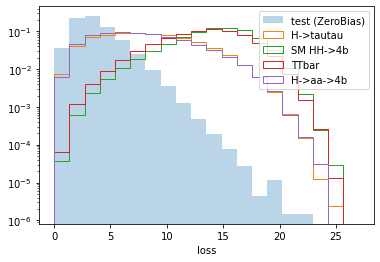

In [14]:
nbins = 20
rmin = 0
rmax = 27
#plt.hist(X_train_predict_qmodel, density = 1, bins = nbins, alpha = 0.3, label = 'train (ZeroBias)', range = (rmin, rmax), log = True)
plt.hist(X_test_predict, density = 1, bins = nbins, alpha = 0.3, label = 'test (ZeroBias)', range = (rmin, rmax), log = True)
#plt.hist(MC_predict_qmodel[0], density = 1, bins = nbins, label = 'QCD', alpha = 0.1, histtype = 'stepfilled', range = (rmin, rmax))
#plt.hist(MC_predict_qmodel[1], density = 1, bins = nbins, label = 'SingleNu', alpha = 0.1, histtype = 'stepfilled', range = (rmin, rmax))
plt.hist(MC_predict[3], density = 1, bins = nbins, label = 'H->tautau', histtype = 'step', range = (rmin, rmax))
plt.hist(MC_predict[4], density = 1, bins = nbins, label = 'SM HH->4b', histtype = 'step', range = (rmin, rmax))
plt.hist(MC_predict[5], density = 1, bins = nbins, label = 'TTbar', histtype = 'step', range = (rmin, rmax))
plt.hist(MC_predict[6], density = 1, bins = nbins, label = 'H->aa->4b', histtype = 'step', range = (rmin, rmax))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend(loc='center left', bbox_to_anchor=(0.57, 0.5))
plt.legend(loc='upper right')
plt.xlabel("loss")
#plt.xticks(np.arange(rmin, rmax, step = 0.0002))
plt.show()

# Knowledge Distillation (+ quantizing with AutoQKeras)

In [ ]:
from qkeras import *
from qkeras.autoqkeras import *

In [ ]:
def metric_for_autoqk(y_true, y_pred):
    loss = 10 - tf.reduce_mean(tf.square(y_true - y_pred), axis = -1)
    return loss

In [ ]:
x_in = layers.Input(shape=(18,14,1),name="In")
x = layers.Flatten(name="Flatten")(x_in)
x = layers.Dense(40,use_bias=False,name="Dense_1")(x)
x = QBatchNormalization(name="QBN_1")(x)
x = layers.Activation('relu',name="Activation_1")(x)
x = layers.Dense(60,use_bias=False,name="Dense_2")(x)
x = QBatchNormalization(name="QBN_2")(x)
x = layers.Activation('relu',name="Activation_2")(x)
x = layers.Dense(1,use_bias=False,name="Out")(x)

qmodel_original = tf.keras.models.Model(x_in, x)
qmodel_original.summary()
qmodel_original.compile(optimizer = 'adam', loss = 'mse', metrics = [metric_for_autoqk])

In [ ]:
quantization_config = {
        "kernel": {
                "quantized_bits(2,0,1,alpha=1.0)": 2,
                "quantized_bits(2,1,1,alpha=1.0)": 2,
                "quantized_bits(3,0,1,alpha=1.0)": 3,
                "quantized_bits(3,1,1,alpha=1.0)": 3,
                "quantized_bits(4,0,1,alpha=1.0)": 4,
                "quantized_bits(4,1,1,alpha=1.0)": 4,
                "quantized_bits(5,0,1,alpha=1.0)": 5,
                "quantized_bits(5,1,1,alpha=1.0)": 5
        },
        "activation": {
                "quantized_relu(2,0)": 2,
                "quantized_relu(2,1)": 2,
                "quantized_relu(3,0)": 3,
                "quantized_relu(3,1)": 3,
                "quantized_relu(4,0)": 4,
                "quantized_relu(4,1)": 4,
                "quantized_relu(5,0)": 5,
                "quantized_relu(5,1)": 5
        }
}

limit = {
    "Dense": [5,5,5], # format for Dense is max bits for [kernel,bias,activation] 
    "Activation": [5] # format for Activation is max bits for [activation]
    #"BatchNormalization": []
}

goal = {
    "type": "bits", # energy, bits
    "params": {
        "delta_p": 8.0,
        "delta_n": 8.0,
        "rate": 2.0,
        "stress": 1.0,
        #"process": "horowitz",
        #"parameters_on_memory": ["sram", "sram"],
        #"activations_on_memory": ["sram", "sram"],
        #"rd_wr_on_io": [False, False],
        #"min_sram_size": [0, 0],
        #"source_quantizers": ["quantized_bits(bits=10,integer=10,symmetric=0,keep_negative=False)"],
        #"reference_internal": "int8",
        #"reference_accumulator": "int32"
        "input_bits": 8,
        "output_bits": 8,
        "ref_bits": 8,
        "config": {
            "default": ["parameters", "activations"]
        }
    }
}

run_config = {
  "output_dir": "run_config",
  "goal": goal,
  "quantization_config": quantization_config,
  "learning_rate_optimizer": False, # False since still experimental
  "transfer_weights": False, # False for the #filters/neurons to float
  "mode": "hyperband", # random/bayesian/hyperband
  "seed": 123,
  "limit": limit,
  "tune_filters": "none", # layer/block/none(no filter tunning at all)
  "tune_filters_exceptions": "",
  #"layer_indexes": range(1 + 1, len(qmodel_original.layers))
  "layer_indexes": (2,4,5,7,8)
}

print("quantizing layers:", [qmodel_original.layers[i].name for i in run_config["layer_indexes"]])

In [ ]:
autoqk = AutoQKeras(qmodel_original, metrics=[metric_for_autoqk], custom_objects={}, **run_config)
autoqk.fit(X_train, X_train_loss, validation_data=(X_val, X_val_loss), batch_size=128, epochs=8)
# i = log(reference_size / trial_size) / log(rate)
# delta = i * ( (i < 0) * delta_n + (i >= 0) * delta_p )
# objective to maximize in the search is
# adjusted score =  metric * (1 + delta), as formulated in the paper

In [ ]:
qmodel = autoqk.get_best_model()

In [ ]:
qmodel.save_weights("qmodel1.h5")

In [ ]:
qmodel.load_weights("qmodel1.h5")

In [ ]:
qmodel.compile(optimizer='adam', loss="mse")
history_qmodel = qmodel.fit(X_train, X_train_loss, epochs=40, batch_size=256, validation_data=(X_val, X_val_loss))

In [ ]:
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history_qmodel.history['loss'], label = 'train loss')
#axes.set_yscale(value = "log")
axes.plot(history_qmodel.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [ ]:
X_train_predict_qmodel = qmodel.predict(X_train)
X_test_predict_qmodel = qmodel.predict(X_test)
MC_predict_qmodel = []
for i in range(len(MC)):
    MC_predict_qmodel.append(qmodel.predict(np.delete(MC[i],[1,2],axis=3)))

In [ ]:
nbins = 20
rmin = 0
rmax = 18
#plt.hist(X_train_predict_qmodel, density = 1, bins = nbins, alpha = 0.3, label = 'train (ZeroBias)', range = (rmin, rmax), log = True)
plt.hist(X_test_predict_qmodel, density = 1, bins = nbins, alpha = 0.3, label = 'test (ZeroBias)', range = (rmin, rmax), log = True)
#plt.hist(MC_predict_qmodel[0], density = 1, bins = nbins, label = 'QCD', alpha = 0.1, histtype = 'stepfilled', range = (rmin, rmax))
#plt.hist(MC_predict_qmodel[1], density = 1, bins = nbins, label = 'SingleNu', alpha = 0.1, histtype = 'stepfilled', range = (rmin, rmax))
plt.hist(MC_predict_qmodel[3], density = 1, bins = nbins, label = 'H->tautau', histtype = 'step', range = (rmin, rmax))
plt.hist(MC_predict_qmodel[4], density = 1, bins = nbins, label = 'SM HH->4b', histtype = 'step', range = (rmin, rmax))
plt.hist(MC_predict_qmodel[5], density = 1, bins = nbins, label = 'TTbar', histtype = 'step', range = (rmin, rmax))
plt.hist(MC_predict_qmodel[6], density = 1, bins = nbins, label = 'H->aa->4b', histtype = 'step', range = (rmin, rmax))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.legend(loc='center left', bbox_to_anchor=(0.57, 0.5))
plt.legend(loc='upper right')
plt.xlabel("loss")
#plt.xticks(np.arange(rmin, rmax, step = 0.0002))
plt.show()

# TensorBoard (less useful)

In [ ]:
%load_ext tensorboard
rm -rf ./logs/
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = "logs/fit", histogram_freq = 1)
%tensorboard --logdir logs/fit

# ROC plotting

### Assigning labels and arranging for ROC plotting

In [8]:
#Baseline
#Assuming only the mean ZB is learned
#Take mean ZB as outputs no matter what inputs are
#Classifier of baseline = MSE(inputs, ZeroBias_mean)
ZeroBias_mean = np.mean(ZeroBias[:,:,:,0].reshape(-1,18,14,1), axis = 0)

baseline_zb = np.mean((X_test[:,:,:,0].reshape(-1,18,14,1) - ZeroBias_mean)**2, axis = (1, 2))
baseline_mc = []
for i in range(len(MC)):
    baseline_mc.append(np.mean((MC[i][:,:,:,0].reshape(-1,18,14,1) - ZeroBias_mean)**2, axis = (1, 2)))

In [15]:
#Assign labels for various signals (y = 1) and backgrounds (y = 0)
Y_zb = np.zeros((X_test.shape[0], 1))
Y_mc = []
for i in range(len(MC)):
    Y_mc.append(np.ones((MC[i].shape[0], 1)))

#Concatenate datasets to make ROC curves, i.e. QCD/SingleNu/signals vs ZB

#True labels
Y_true = []
#Baseline scores
Y_baseline = []
#Model scores
Y_model = []
Y_qmodel = []

for i in range(len(MC)):
    Y_true.append(np.concatenate((Y_mc[i], Y_zb)))
    Y_baseline.append(np.concatenate((baseline_mc[i], baseline_zb)))
    #Y_model.append(np.concatenate((MC_loss[i], X_test_loss)))
    Y_qmodel.append(np.concatenate((MC_predict[i], X_test_predict)))

### Baseline ROC

In [ ]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_baseline = []
tpr_baseline = []
thresholds_baseline = []
roc_auc_baseline = []
for i in range(len(MC)):
    fpr_baseline.append(np.empty((Y_true[i].shape[0],1)))
    tpr_baseline.append(np.empty((Y_true[i].shape[0],1)))
    thresholds_baseline.append(np.empty((Y_true[i].shape[0],1)))
    roc_auc_baseline.append(np.empty((Y_true[i].shape[0],1)))
    fpr_baseline[i], tpr_baseline[i], thresholds_baseline[i] = roc_curve(Y_true[i], Y_baseline[i])
    roc_auc_baseline[i] = auc(fpr_baseline[i], tpr_baseline[i])
    fpr_baseline[i] *= 28.61
    if i == 0:
        print(1)
        #axes.plot(fpr_model[i], tpr_model[i], linestyle = '--', color = 'r', lw = 1, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_model[i]))
    if i == 1 or i == 2:
        print(1)
        #axes.plot(fpr_model[i], tpr_model[i], linestyle = ':', lw = 1, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_model[i]))
    if i == 3:
        #axes.plot(fpr_model[3], tpr_model[3], linestyle = '--', lw = 1, color = 'blue', label = 'SM H->2tau (AUC = %.5f)' % (roc_auc_model[3]))
        axes.plot(fpr_baseline[3], tpr_baseline[3], linestyle = '-', lw = 1.5, color = 'green', label = 'H->2Tau (AUC = %.5f)' % (roc_auc_baseline[3]))
    if i == 4:
        #axes.plot(fpr_model[4], tpr_model[4], linestyle = '--', lw = 1, color = 'orange', label = 'SM HH->4b (AUC = %.5f)' % (roc_auc_model[4]))
        axes.plot(fpr_baseline[4], tpr_baseline[4], linestyle = '-', lw = 1.5, color = 'red', label = 'SM HH->4b (AUC = %.5f)' % (roc_auc_baseline[4]))
    if i == 5:
        #axes.plot(fpr_model[5], tpr_model[5], linestyle = '--', lw = 1, color = 'green', label = 'H->2LongLived->4b (AUC = %.5f)' % (roc_auc_model[5]))
        axes.plot(fpr_baseline[5], tpr_baseline[5], linestyle = '-', lw = 1.5, color = 'blue', label = 'TTbar (AUC = %.5f)' % (roc_auc_baseline[5]))
    if i == 6:
        #axes.plot(fpr_model[6], tpr_model[6], linestyle = '--', lw = 1, color = 'red', label = 'TTbar (AUC = %.5f)' % (roc_auc_model[6]))
        axes.plot(fpr_baseline[6], tpr_baseline[6], linestyle = '-', lw = 1.5, color = 'orange', label = 'H->aa->4b (AUC = %.5f)' % (roc_auc_baseline[6]))
axes.plot([0.005, 0.005], [0, 1], linestyle = '--', lw = 1, color = 'black', label = 'FPR = 0.0175% ~ (5 kHz)/(ZeroBias 28.61 MHz)')
axes.set_xlim([0.0002861, 28.61])
axes.set_ylim([0.000001, 1.0])
axes.set_xscale(value = "log")
axes.set_yscale(value = "log")
axes.set_xlabel('Trigger Rate (MHz)',size=15)
axes.set_ylabel('Signal Efficiency',size=15)
axes.set_title('Baseline (energy based)',size=15)
axes.legend(loc='center left', bbox_to_anchor = (0.5, 0.5),fontsize=12)
plt.show()

### Teacher model ROC

In [ ]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_model = []
tpr_model = []
thresholds_model = []
roc_auc_model = []
for i in range(len(MC)):
    fpr_model.append(np.empty((Y_true[i].shape[0],1)))
    tpr_model.append(np.empty((Y_true[i].shape[0],1)))
    thresholds_model.append(np.empty((Y_true[i].shape[0],1)))
    roc_auc_model.append(np.empty((Y_true[i].shape[0],1)))
    fpr_model[i], tpr_model[i], thresholds_model[i] = roc_curve(Y_true[i], Y_model[i])
    roc_auc_model[i] = auc(fpr_model[i], tpr_model[i])
    fpr_model[i] *= 28.61
    if i == 0:
        print(1)
        #axes.plot(fpr_model[i], tpr_model[i], linestyle = '--', color = 'r', lw = 1, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_model[i]))
    if i == 1 or i == 2:
        print(1)
        #axes.plot(fpr_model[i], tpr_model[i], linestyle = ':', lw = 1, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_model[i]))
    if i == 3:
        #axes.plot(fpr_model[3], tpr_model[3], linestyle = '--', lw = 1, color = 'blue', label = 'SM H->2tau (AUC = %.5f)' % (roc_auc_model[3]))
        axes.plot(fpr_model[3], tpr_model[3], linestyle = '-', lw = 1.5, color = 'green', label = 'H->tautau (AUC = %.5f)' % (roc_auc_model[3]))
    if i == 4:
        #axes.plot(fpr_model[4], tpr_model[4], linestyle = '--', lw = 1, color = 'orange', label = 'SM HH->4b (AUC = %.5f)' % (roc_auc_model[4]))
        axes.plot(fpr_model[4], tpr_model[4], linestyle = '-', lw = 1.5, color = 'red', label = 'SM HH->4b (AUC = %.5f)' % (roc_auc_model[4]))
    if i == 5:
        #axes.plot(fpr_model[5], tpr_model[5], linestyle = '--', lw = 1, color = 'green', label = 'H->2LongLived->4b (AUC = %.5f)' % (roc_auc_model[5]))
        axes.plot(fpr_model[5], tpr_model[5], linestyle = '-', lw = 1.5, color = 'blue', label = 'TTbar (AUC = %.5f)' % (roc_auc_model[5]))
    if i == 6:
        #axes.plot(fpr_model[6], tpr_model[6], linestyle = '--', lw = 1, color = 'red', label = 'TTbar (AUC = %.5f)' % (roc_auc_model[6]))
        axes.plot(fpr_model[6], tpr_model[6], linestyle = '-', lw = 1.5, color = 'orange', label = 'H->aa->4b (AUC = %.5f)' % (roc_auc_model[6]))
axes.plot([0.005, 0.005], [0, 1], linestyle = '--', lw = 1, color = 'black', label = 'Trigger rate = 5 kHz')
axes.set_xlim([0.0002861, 28.61])
axes.set_ylim([0.000001, 1.0])
axes.set_xscale(value = "log")
axes.set_yscale(value = "log")
axes.set_xlabel('Trigger Rate (MHz)',size=15)
axes.set_ylabel('Signal Efficiency',size=15)
axes.set_title('Teacher model',size=15)
axes.legend(loc='center left', bbox_to_anchor = (0.3, 0.5),fontsize=12)
plt.show()

### Student model ROC

1
1
1


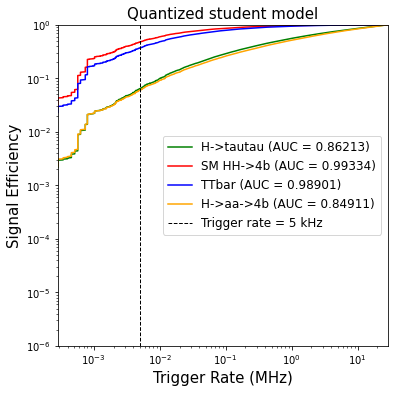

In [16]:
plt.figure(figsize = (13, 13))
axes = plt.subplot(2, 2, 1)
fpr_qmodel = []
tpr_qmodel = []
thresholds_qmodel = []
roc_auc_qmodel = []
for i in range(len(MC)):
    fpr_qmodel.append(np.empty((Y_true[i].shape[0],1)))
    tpr_qmodel.append(np.empty((Y_true[i].shape[0],1)))
    thresholds_qmodel.append(np.empty((Y_true[i].shape[0],1)))
    roc_auc_qmodel.append(np.empty((Y_true[i].shape[0],1)))
    fpr_qmodel[i], tpr_qmodel[i], thresholds_qmodel[i] = roc_curve(Y_true[i], Y_qmodel[i])
    roc_auc_qmodel[i] = auc(fpr_qmodel[i], tpr_qmodel[i])
    fpr_qmodel[i] *= 28.61
    if i == 0:
        print(1)
        #axes.plot(fpr_qmodel[i], tpr_qmodel[i], linestyle = '--', color = 'r', lw = 1, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_qmodel[i]))
    if i == 1 or i == 2:
        print(1)
        #axes.plot(fpr_qmodel[i], tpr_qmodel[i], linestyle = ':', lw = 1, label = MC_files[i] + ' (AUC = %.8f)' % (roc_auc_qmodel[i]))
    if i == 3:
        #axes.plot(fpr_qmodel[3], tpr_qmodel[3], linestyle = '--', lw = 1, color = 'blue', label = 'SM H->2tau (AUC = %.5f)' % (roc_auc_qmodel[3]))
        axes.plot(fpr_qmodel[3], tpr_qmodel[3], linestyle = '-', lw = 1.5, color = 'green', label = 'H->tautau (AUC = %.5f)' % (roc_auc_qmodel[3]))
    if i == 4:
        #axes.plot(fpr_qmodel[4], tpr_qmodel[4], linestyle = '--', lw = 1, color = 'orange', label = 'SM HH->4b (AUC = %.5f)' % (roc_auc_qmodel[4]))
        axes.plot(fpr_qmodel[4], tpr_qmodel[4], linestyle = '-', lw = 1.5, color = 'red', label = 'SM HH->4b (AUC = %.5f)' % (roc_auc_qmodel[4]))
    if i == 5:
        #axes.plot(fpr_qmodel[5], tpr_qmodel[5], linestyle = '--', lw = 1, color = 'green', label = 'H->2LongLived->4b (AUC = %.5f)' % (roc_auc_qmodel[5]))
        axes.plot(fpr_qmodel[5], tpr_qmodel[5], linestyle = '-', lw = 1.5, color = 'blue', label = 'TTbar (AUC = %.5f)' % (roc_auc_qmodel[5]))
    if i == 6:
        #axes.plot(fpr_qmodel[6], tpr_qmodel[6], linestyle = '--', lw = 1, color = 'red', label = 'TTbar (AUC = %.5f)' % (roc_auc_qmodel[6]))
        axes.plot(fpr_qmodel[6], tpr_qmodel[6], linestyle = '-', lw = 1.5, color = 'orange', label = 'H->aa->4b (AUC = %.5f)' % (roc_auc_qmodel[6]))
axes.plot([0.005, 0.005], [0, 1], linestyle = '--', lw = 1, color = 'black', label = 'Trigger rate = 5 kHz')
axes.set_xlim([0.0002861, 28.61])
axes.set_ylim([0.000001, 1.0])
axes.set_xscale(value = "log")
axes.set_yscale(value = "log")
axes.set_xlabel('Trigger Rate (MHz)',size=15)
axes.set_ylabel('Signal Efficiency',size=15)
axes.set_title('Quantized student model',size=15)
axes.legend(loc='center left', bbox_to_anchor = (0.3, 0.5),fontsize=12)
plt.show()

In [ ]:
table_tpr_baseline = []
table_tpr_model = []
table_tpr_qmodel = []
table_tpr_change = []
for i in range(len(fpr_baseline)):
    for j in range(len(fpr_baseline[i])):
        if fpr_baseline[i][j] > 0.005:
            table_tpr_baseline.append(tpr_baseline[i][j] * 100)
            break
    for j in range(len(fpr_model[i])):
        if fpr_model[i][j] > 0.005:
            table_tpr_model.append(tpr_model[i][j] * 100)
            break
    for j in range(len(fpr_qmodel[i])):
        if fpr_qmodel[i][j] > 0.005:
            table_tpr_qmodel.append(tpr_qmodel[i][j] * 100)
            break

#for i in range(len(MC)):
    #table_tpr_change.append(100 * (table_tpr_model[i] - table_tpr_baseline[i])/table_tpr_baseline[i])

MC_names = ['H->tautau','SM HH->4b','TTbar','H->aa->4b']
table_tpr = pd.DataFrame({'Baseline': table_tpr_baseline[3:],
                          'Model(Et)': table_tpr_model[3:],
                          'QStudent(Et)': table_tpr_qmodel[3:]},
                         index = MC_names)
#table_tpr = table_tpr.sort_values(by = 'delta', ascending = False)

pd.set_option('display.max_colwidth', None)
table_tpr

In [ ]:
table_tpr_model = []
table_tpr_model_bits = []
table_tpr_change = []
for i in range(len(fpr_model)):
    for j in range(len(fpr_model[i])):
        if fpr_model[i][j] > 0.000175:
            table_tpr_model.append(np.round(tpr_model[i][j] * 100,3))
            break
    for j in range(len(fpr_model_bits[i])):
        if fpr_model_bits[i][j] > 0.000175:
            table_tpr_model_bits.append(np.round(tpr_model_bits[i][j] * 100,3))
            break

for i in range(len(MC)):
    table_tpr_change.append(np.round(100 * (table_tpr_model_bits[i] - table_tpr_model[i])/table_tpr_model[i],3))
    #table_tpr_change.append(-table_tpr_student[i] + table_tpr_qmodel[i])

table_tpr = pd.DataFrame({'Model(Et)': table_tpr_model[3:],
                          'Model(Et, Taubit)': table_tpr_model_bits[3:],
                          '% more sensitive': table_tpr_change[3:]},
                         index = MC_files[3:])
#table_tpr = table_tpr.sort_values(by = 'delta(qDense, Dense)', ascending = False)

pd.set_option('display.max_colwidth', None)
table_tpr